In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .getOrCreate()


In [6]:
dfrm1=spark.read.csv('imdb_top_1000.csv',header=True,inferSchema=True)

In [7]:
dfrm1.printSchema()

root
 |-- Poster_Link: string (nullable = true)
 |-- Series_Title: string (nullable = true)
 |-- Released_Year: string (nullable = true)
 |-- Certificate: string (nullable = true)
 |-- Runtime: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- IMDB_Rating: double (nullable = true)
 |-- Overview: string (nullable = true)
 |-- Meta_score: string (nullable = true)
 |-- Director: string (nullable = true)
 |-- Star1: string (nullable = true)
 |-- Star2: string (nullable = true)
 |-- Star3: string (nullable = true)
 |-- Star4: string (nullable = true)
 |-- No_of_Votes: string (nullable = true)
 |-- Gross: string (nullable = true)



In [8]:
dfrm1.show()

+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+-----------+
|         Poster_Link|        Series_Title|Released_Year|Certificate|Runtime|               Genre|IMDB_Rating|            Overview|Meta_score|            Director|             Star1|               Star2|             Star3|               Star4|No_of_Votes|      Gross|
+--------------------+--------------------+-------------+-----------+-------+--------------------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+-----------+
|https://m.media-a...|The Shawshank Red...|         1994|          A|142 min|               Drama|        9.3|Two imprisoned me...|        80|      Frank Darabont|       Tim Robbins|      Morgan F

In [9]:
dfrm1.dtypes

[('Poster_Link', 'string'),
 ('Series_Title', 'string'),
 ('Released_Year', 'string'),
 ('Certificate', 'string'),
 ('Runtime', 'string'),
 ('Genre', 'string'),
 ('IMDB_Rating', 'double'),
 ('Overview', 'string'),
 ('Meta_score', 'string'),
 ('Director', 'string'),
 ('Star1', 'string'),
 ('Star2', 'string'),
 ('Star3', 'string'),
 ('Star4', 'string'),
 ('No_of_Votes', 'string'),
 ('Gross', 'string')]

In [10]:
dfrm1=dfrm1.drop('Poster_Link')
dfrm1=dfrm1.drop('Overreview')

In [41]:
from pyspark.sql.functions import regexp_replace,col
dfrm1 = dfrm1.withColumn("Gross", regexp_replace(col("Gross"), ",", "").cast("float"))
dfrm1 = dfrm1.withColumn("No_of_votes", regexp_replace(col("No_of_Votes"), ",", "").cast("int"))
dfrm1=dfrm1.withColumn('imdb_rating',regexp_replace(col('imdb_rating'),",","").cast("float"))
dfrm1.show()

+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+------------+---------+---------+--------+
|        Series_Title|Released_Year|Certificate|Runtime|imdb_rating|            Overview|Meta_score|            Director|             Star1|               Star2|             Star3|               Star4|No_of_votes|       Gross|  Genre_1|  Genre_2| Genre_3|
+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+------------+---------+---------+--------+
|The Shawshank Red...|         1994|          A|142 min|        9.3|Two imprisoned me...|        80|      Frank Darabont|       Tim Robbins|      Morgan Freeman|        Bob Gunton|      William Sadler|    2343110| 2.8341468E7|    Dr

In [42]:
from pyspark.sql.functions import col,count,isnan,when
dfrm1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfrm1.columns]
   ).show()

+------------+-------------+-----------+-------+-----------+--------+----------+--------+-----+-----+-----+-----+-----------+-----+-------+-------+-------+
|Series_Title|Released_Year|Certificate|Runtime|imdb_rating|Overview|Meta_score|Director|Star1|Star2|Star3|Star4|No_of_votes|Gross|Genre_1|Genre_2|Genre_3|
+------------+-------------+-----------+-------+-----------+--------+----------+--------+-----+-----+-----+-----+-----------+-----+-------+-------+-------+
|           0|            0|          0|      0|          0|       0|         0|       0|    0|    0|    0|    0|         14|    0|      0|    105|    354|
+------------+-------------+-----------+-------+-----------+--------+----------+--------+-----+-----+-----+-----+-----------+-----+-------+-------+-------+



In [43]:
from pyspark.sql.functions import mean
mean_value=dfrm1.select(mean(dfrm1['Meta_score'])).collect()[0][0]
mean_value1=dfrm1.select(mean(dfrm1['Gross'])).collect()[0][0]
dfrm1 = dfrm1.na.fill({'Certificate': 'U'})
dfrm1=dfrm1.na.fill({'Meta_score':mean_value})
dfrm1=dfrm1.na.fill({'Gross':mean_value1})
dfrm1.show()


+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+------------+---------+---------+--------+
|        Series_Title|Released_Year|Certificate|Runtime|imdb_rating|            Overview|Meta_score|            Director|             Star1|               Star2|             Star3|               Star4|No_of_votes|       Gross|  Genre_1|  Genre_2| Genre_3|
+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+------------+---------+---------+--------+
|The Shawshank Red...|         1994|          A|142 min|        9.3|Two imprisoned me...|        80|      Frank Darabont|       Tim Robbins|      Morgan Freeman|        Bob Gunton|      William Sadler|    2343110| 2.8341468E7|    Dr

In [14]:
directors=dfrm1.filter(col('Director').isNull() | isnan(col('Director')))
directors.show()
dfrm1=dfrm1.withColumn("Director",when(col('Series_title')=="Zelig","Woody Allen").otherwise(col('Director')))


+------------+-------------+-----------+-------+------+-----------+--------------------+--------------------+--------+-----------+-----------+----------+--------------+-----------+-----+
|Series_Title|Released_Year|Certificate|Runtime| Genre|IMDB_Rating|            Overview|          Meta_score|Director|      Star1|      Star2|     Star3|         Star4|No_of_votes|Gross|
+------------+-------------+-----------+-------+------+-----------+--------------------+--------------------+--------+-----------+-----------+----------+--------------+-----------+-----+
|       Zelig|         1983|         PG| 79 min|Comedy|        7.7|"""Documentary"" ...| and meets variou...|    NULL|Woody Allen|Woody Allen|Mia Farrow|Patrick Horgan|       NULL|39881|
+------------+-------------+-----------+-------+------+-----------+--------------------+--------------------+--------+-----------+-----------+----------+--------------+-----------+-----+



In [15]:
dfrm1.createOrReplaceTempView('dfrm1')

In [16]:
from pyspark.sql.functions import split, col
df_split = dfrm1.withColumn('Genre', split(col('Genre'), ', '))
dfrm1 = df_split.withColumn('Genre_1', col('Genre').getItem(0)) \
                   .withColumn('Genre_2', col('Genre').getItem(1)) \
                   .withColumn('Genre_3', col('Genre').getItem(2))

In [17]:
dfrm1=dfrm1.drop('Genre')

In [18]:
dfrm1.show()

+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+---------+---------+---------+--------+
|        Series_Title|Released_Year|Certificate|Runtime|IMDB_Rating|            Overview|Meta_score|            Director|             Star1|               Star2|             Star3|               Star4|No_of_votes|    Gross|  Genre_1|  Genre_2| Genre_3|
+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+---------+---------+---------+--------+
|The Shawshank Red...|         1994|          A|142 min|        9.3|Two imprisoned me...|        80|      Frank Darabont|       Tim Robbins|      Morgan Freeman|        Bob Gunton|      William Sadler|    2343110| 28341469|    Drama|     NUL

In [19]:
df_filled = dfrm1.fillna("Unknown", subset=["genre_1", "genre_2", "genre_3"])


In [20]:
df_filled.show()

+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+---------+---------+---------+--------+
|        Series_Title|Released_Year|Certificate|Runtime|IMDB_Rating|            Overview|Meta_score|            Director|             Star1|               Star2|             Star3|               Star4|No_of_votes|    Gross|  Genre_1|  Genre_2| Genre_3|
+--------------------+-------------+-----------+-------+-----------+--------------------+----------+--------------------+------------------+--------------------+------------------+--------------------+-----------+---------+---------+---------+--------+
|The Shawshank Red...|         1994|          A|142 min|        9.3|Two imprisoned me...|        80|      Frank Darabont|       Tim Robbins|      Morgan Freeman|        Bob Gunton|      William Sadler|    2343110| 28341469|    Drama|  Unknow

In [21]:
query = """
    SELECT Director, COUNT(*) as Movie_Count
    FROM dfrm1
    GROUP BY Director order by Movie_Count DESC
"""

In [22]:
q=spark.sql(query)

In [23]:
q.show()

+-----------------+-----------+
|         Director|Movie_Count|
+-----------------+-----------+
| Alfred Hitchcock|         14|
| Steven Spielberg|         12|
|   Hayao Miyazaki|         11|
|   Akira Kurosawa|         10|
|  Martin Scorsese|         10|
|  Stanley Kubrick|          9|
|      Woody Allen|          9|
|     Billy Wilder|          9|
|   Clint Eastwood|          8|
|    David Fincher|          8|
|Christopher Nolan|          8|
|Quentin Tarantino|          8|
|     Howard Hawks|          7|
|       Rob Reiner|          7|
|   Ingmar Bergman|          7|
|Richard Linklater|          6|
|   Alfonso Cuarón|          6|
|  Charles Chaplin|          6|
|     Ridley Scott|          6|
|     Wes Anderson|          6|
+-----------------+-----------+
only showing top 20 rows



In [24]:
query2="""
select series_title,imdb_rating,No_of_votes from dfrm1 order by no_of_votes DESC
"""
q2=spark.sql(query2)

In [25]:
q2.show()

+--------------------+-----------+-----------+
|        series_title|imdb_rating|No_of_votes|
+--------------------+-----------+-----------+
|The Shawshank Red...|        9.3|    2343110|
|     The Dark Knight|        9.0|    2303232|
|           Inception|        8.8|    2067042|
|          Fight Club|        8.8|    1854740|
|        Pulp Fiction|        8.9|    1826188|
|        Forrest Gump|        8.8|    1809221|
|          The Matrix|        8.7|    1676426|
|The Lord of the R...|        8.8|    1661481|
|The Lord of the R...|        8.9|    1642758|
|       The Godfather|        9.2|    1620367|
|The Dark Knight R...|        8.4|    1516346|
|        Interstellar|        8.6|    1512360|
|The Lord of the R...|        8.7|    1485555|
|               Se7en|        8.6|    1445096|
|    Django Unchained|        8.4|    1357682|
|           Gladiator|        8.5|    1341460|
|       Batman Begins|        8.2|    1308302|
|The Silence of th...|        8.6|    1270197|
|Inglourious 

In [26]:
from pyspark.sql import functions as F
melted_df = dfrm1.select("series_title", F.explode(F.array("genre_1", "genre_2", "genre_3")).alias("genre")) \
    .na.drop(subset=["genre"])
genre_count = melted_df.groupBy("genre").count().orderBy("count", ascending=False)
genre_count.show()


+---------+-----+
|    genre|count|
+---------+-----+
|    Drama|  724|
|   Comedy|  233|
|    Crime|  209|
|Adventure|  196|
|   Action|  189|
| Thriller|  137|
|  Romance|  125|
|Biography|  109|
|  Mystery|   99|
|Animation|   82|
|   Sci-Fi|   67|
|  Fantasy|   66|
|   Family|   56|
|  History|   56|
|      War|   51|
|    Music|   35|
|   Horror|   32|
|  Western|   20|
|Film-Noir|   19|
|    Sport|   19|
+---------+-----+
only showing top 20 rows



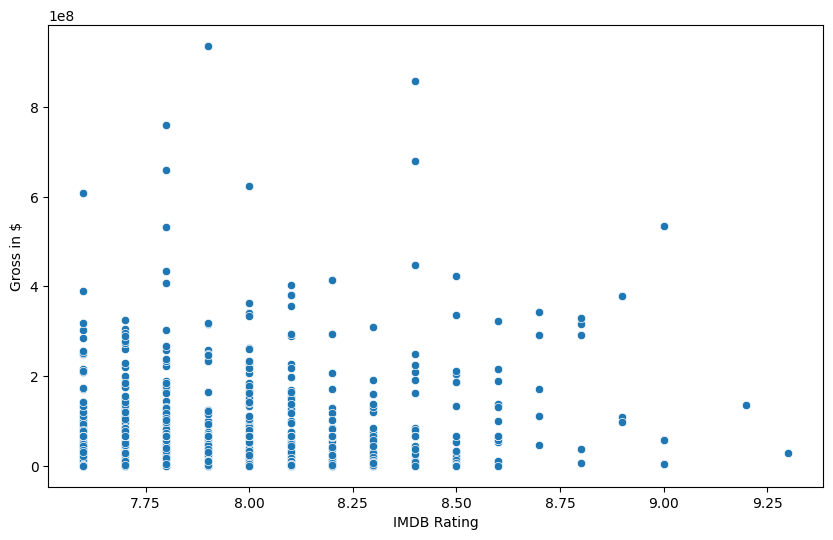

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
temp=dfrm1.select('imdb_rating','gross').toPandas()
plt.figure(figsize=(10,6))
sns.scatterplot(data=temp,x='imdb_rating',y='gross')
plt.xlabel('IMDB Rating')
plt.ylabel('Gross in $')
plt.show()

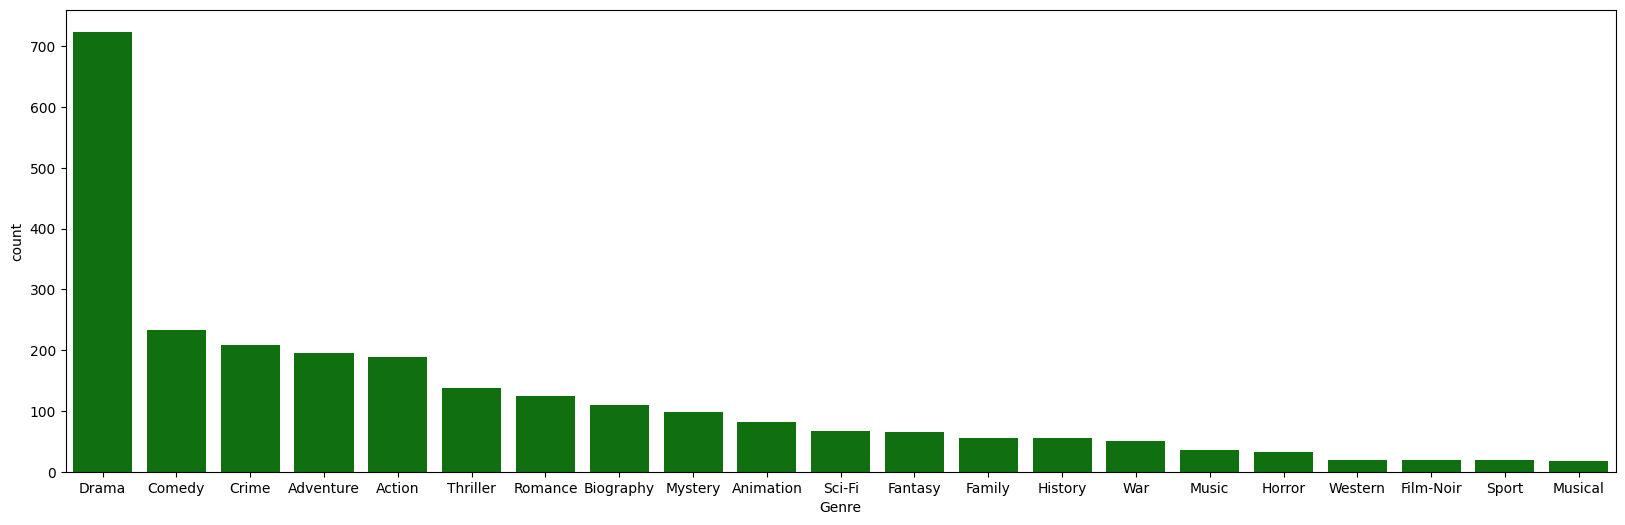

In [52]:
temp2=genre_count.select('genre','count').toPandas()
plt.figure(figsize=(20,6))
sns.barplot(data=temp2,x='genre',y='count',color='green')
plt.xlabel('Genre')
plt.ylabel('count')
plt.show()

,genre,count
0,Drama,724
1,Comedy,233
2,Crime,209
3,Adventure,196
4,Action,189
5,Thriller,137
6,Romance,125
7,Biography,109
8,Mystery,99
9,Animation,82
